# Review of exercise 5

(c) 2017 Justin Bois and Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](l41_exercise_5.ipynb).*

In [1]:
# Modules for interacting with our file system. 
import os
import glob

# Number crunching
import numpy as np
import scipy.optimize

# Modules for image processing
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.measure

import bootcamp_utils

# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Problem 5.1: Growth curves from a movie

At the dawn of the molecular revolution in biology, key experiments by Jacques Monod in which he measured growth curves of bacteria under different conditions exposed some of the mechanisms of regulation of gene expression.  Those growth curves were measured in a bulk solution.  In this exercise, we will measure bacterial growth starting from a *two bacteria*.  The movie shows *Bacillus subtilis* constitutively expressing mCherry growing under slow growth conditions.  These data were kindly donated by Jin Park from the Elowitz lab here at Caltech.

**a)** Load in the series of images contained in the directory `data/bacterial_growth/`. Be sure that however you store them (a list or tuple or other object) has the frames in the proper order.

**b)** Segment the images to separate bacteria from background.  You do not need to segment individual bacteria; this would likely require some more advanced techniques involving edge detection that we haven't covered in bootcamp.

**c)** Show a representative image from the stack (with the segmentation overlayed in green) of images with a 10 µm scale bar burned in. Be sure to check out the `README` file in the directory containing the images to get the interpixel distance.

**d)** If $m$ is the mass of bacteria, which is proportional to the area in the images, then, for exponential growth,

\begin{align}
m(t) = m_0\,\mathrm{e}^{rt},
\end{align}

where $r$ is the growth rate. Taking the logarithm of both sides gives

\begin{align}
\ln m(t) = \ln m_0 + rt.
\end{align}

So, the slope of the line on a log-log scale is the growth rate.

With this in mind, plot the bacterial area as a function of time with the area on a log scale. If the plot is linear, the bacteria are performing exponential growth.

**e)** To get the slope of the line, you can use the `np.polyfit()` function. Read the documentation for that function, and then use it to get the growth rate. Once you find the growth rate (and intercept), plot the theoretical growth curve along with the data.

### Problem 5.1: solution

**a)** We will load the images into a tuple, where the index of the tuple corresponds to the frame number.  Under normal circumstances, we would do data validation to make sure there are no skipped frames, but in the interest of brevity, we will proceed assuming all data are properly labeled and organized.

In [2]:
# Use a list comprehension to read in the images
ims = [skimage.io.imread(fname) for fname in glob.glob('data/bacterial_growth/bacillus_*.tif')]

# Store it as a tuple so we don't mess with it
ims = tuple(ims)

# How many?
print('There are', len(ims), 'images.')

There are 55 images.


Let's take a quick look at a few of the images.  We'll look at frames `0`, `15`, `30`, and `45`.

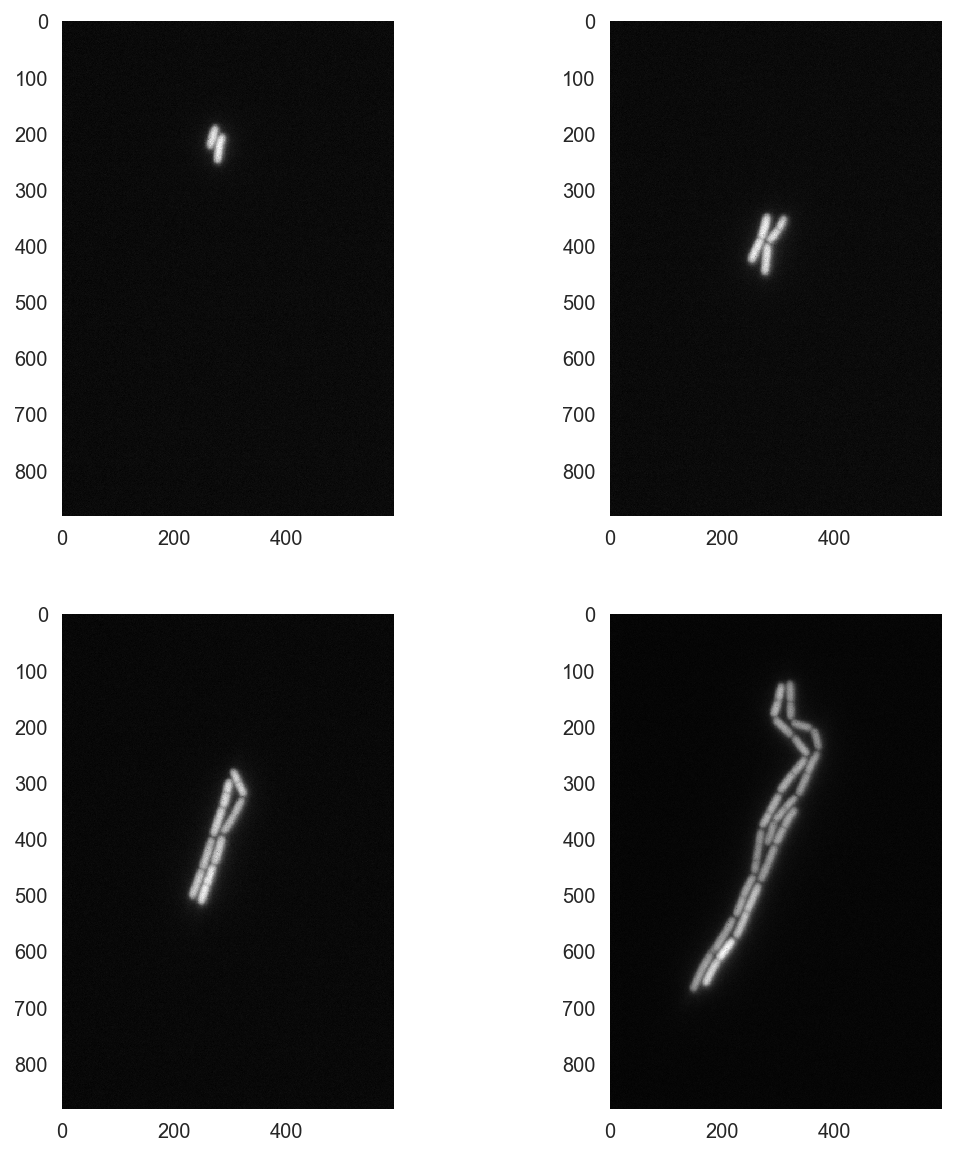

In [3]:
# Display phase and thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9, 10))
    ax[0,0].imshow(ims[0], cmap=plt.cm.gray)
    ax[0,1].imshow(ims[15], cmap=plt.cm.gray)
    ax[1,0].imshow(ims[30], cmap=plt.cm.gray)
    ax[1,1].imshow(ims[45], cmap=plt.cm.gray)

**b)** We will take a similar approach as in [Lesson 38](l38_intro_to_image_processing.html) to segment the image.  We will simply threshold the image using Otsu's method.

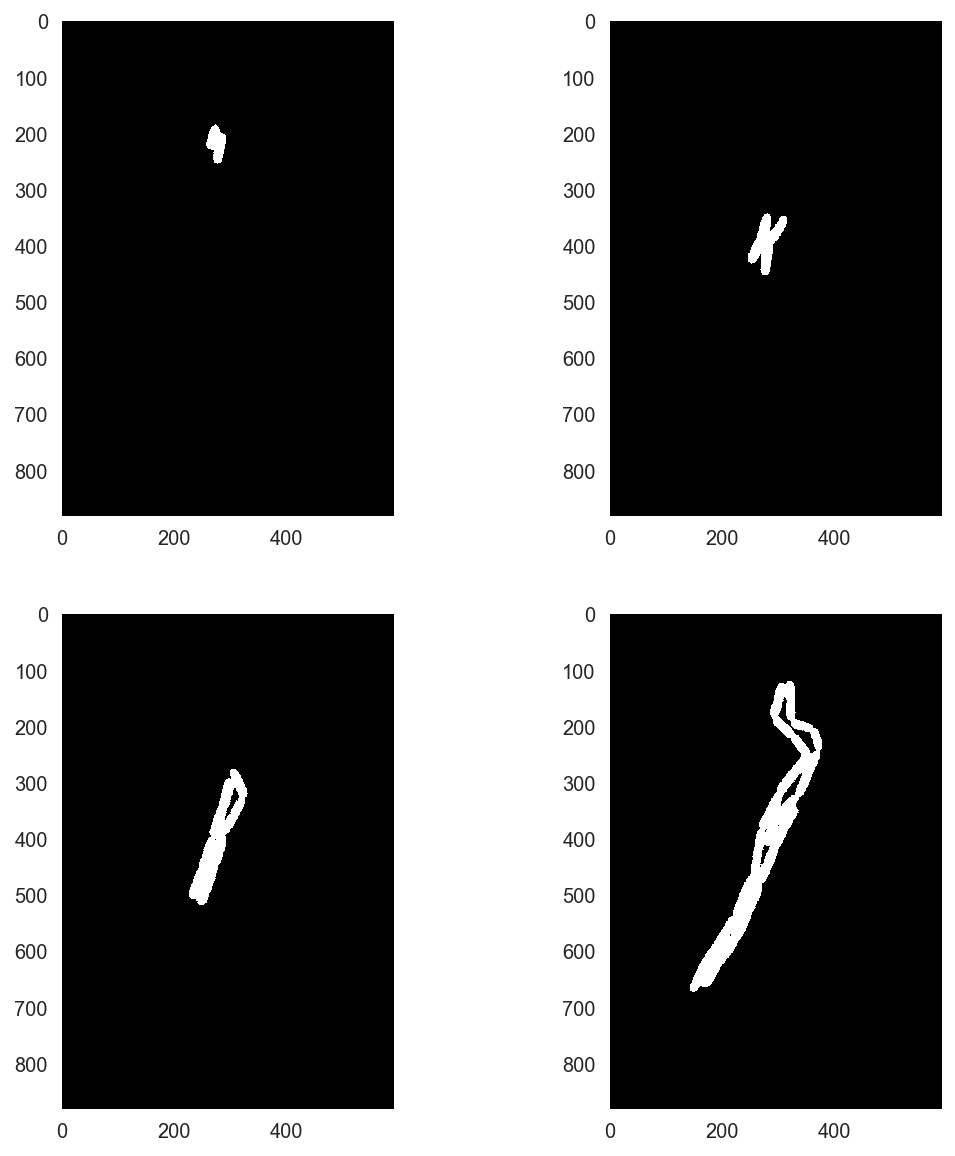

In [4]:
# Threshold each image
ims_bw = [im > skimage.filters.threshold_otsu(im) for im in ims]

# Take a look at the result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9, 10))
    ax[0,0].imshow(ims_bw[0], cmap=plt.cm.gray)
    ax[0,1].imshow(ims_bw[15], cmap=plt.cm.gray)
    ax[1,0].imshow(ims_bw[30], cmap=plt.cm.gray)
    ax[1,1].imshow(ims_bw[45], cmap=plt.cm.gray)

This is pretty good.  Certainly good enough for generating a growth curve.

**c)** We will overlay the segmentation on image 40.  We'll use the green channel.  To burn in the scale bar, we remember that images are stored as NumPy arrays.  In looking at the README file associated with the images, the interpixel distance is 64.5 nm.  So, we need the scale bar to be $10 / 0.0645 = 155$ pixels long.  We will burn it in the lower right corner.

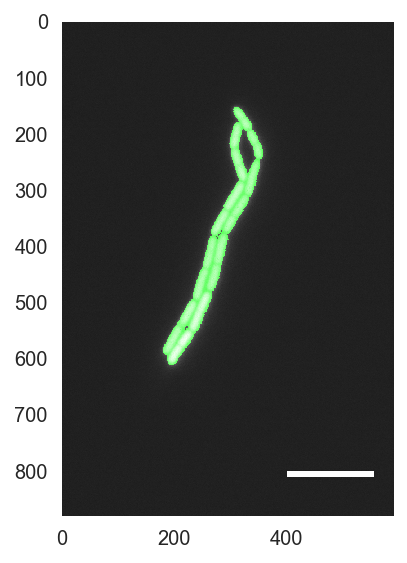

In [5]:
# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:555] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    skimage.io.imshow(im_rgb)

The segmentation overshoots the bacteria.  We might want to try to refine this a bit.  We could do **adaptive thresholding**.  We perform automatic thresholding on subimages throughout the image.  We will take subimages to be 51 $\times$ 51, since that would span the width of one bacterium, and then some, thereby avoiding the issue of thresholding within a single bacterium (and adaptive thresholding needs an off image block size).  Adaptive thresholding is achieved using `skimage.filters.threshold_local()`. Let's give it a shot.

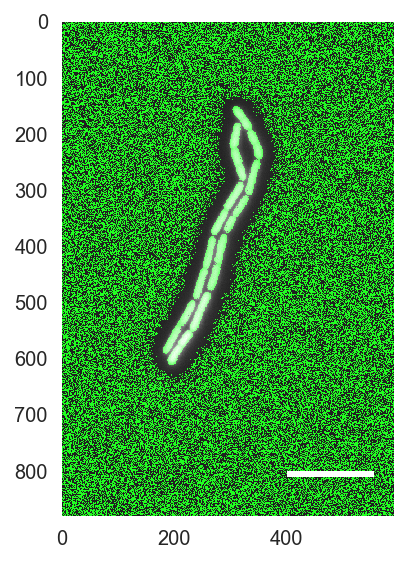

In [6]:
# Initialize list of thresholded images
ims_bw = [im > skimage.filters.threshold_local(im, 51) for im in ims]

# Image to use for visualization, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:555] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    skimage.io.imshow(im_rgb)

Whoa!  It did a great job with the bacteria, but the background got really messed up.  We could include pixels that are unity in both the adaptive and Otsu thresholding to take care of this.  We then use `np.logical_and()` to do an element-by-element `AND` operation on the arrays.

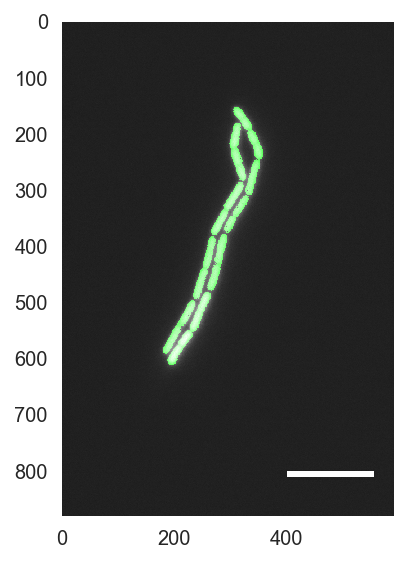

In [7]:
def thresh(im, block_size=51):
    """Combined adaptive and Otsu thresholding."""
    thresh_otsu = skimage.filters.threshold_otsu(im)
    im_bw = im > thresh_otsu
    return np.logical_and(im > skimage.filters.threshold_local(im, 51), im_bw)
    
# Theshold images
ims_bw = [thresh(im) for im in ims]

# Image to use for display, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:555] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    skimage.io.imshow(im_rgb)

Very nice!

**d)** To plot the growth curve, we can plot the total bacterial area on the $y$-axis (on a log scale), versus time on the $x$-axis.  To get the total area, we need to compute the total number of "bacterial" pixels in a given image, multiplied by the pixel area, which is $(64.5\text{ nm})^2 = 4160.25\text{ nm}^2$.  Also, according to the metadata, we have one frame every 15 minutes.

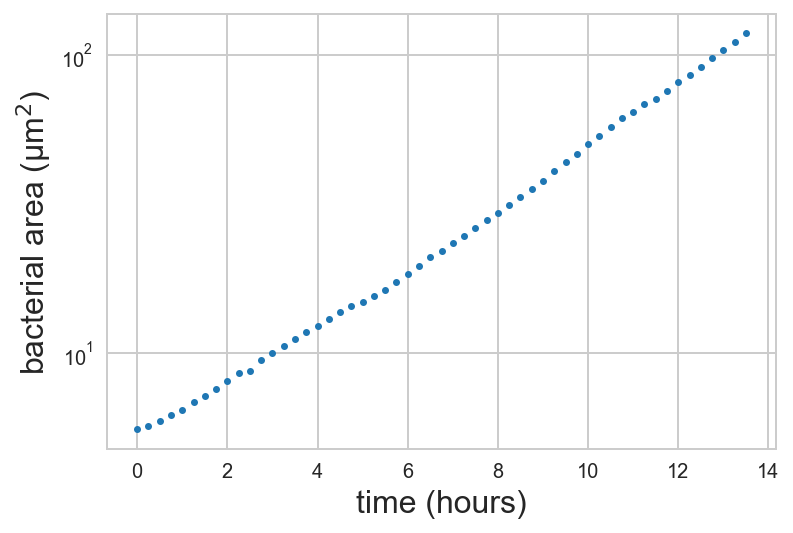

In [8]:
# Compute pixel area
pixel_area = 0.0645**2

# Get total bacterial area
bac_area = pixel_area * np.array([np.sum(im_bw) for im_bw in ims_bw])
   
# Get time in units of hours
t = 0.25 * np.arange(len(ims_bw))

# Plot the result
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time (hours)')
ax.set_ylabel('bacterial area (µm$^2$)')
ax.set_yscale('log')
_ = ax.plot(t, bac_area, marker='.', linestyle='none')

This looks pretty linear, suggesting that the bacteria are, indeed, performing exponential growth.

**e)** To perform the regression on the growth curve, we use `np.polyfit()` with the `x` values being time, and the `y` values being the natural log of the bacterial area. We fit with a first order polynomial, which is a line.


m0 = 4.96 sq. µm
 r = 0.23 1/hours



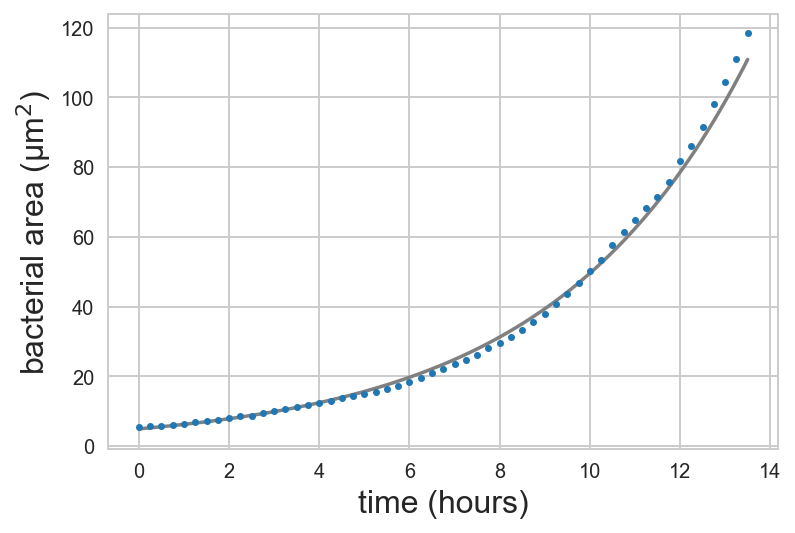

In [9]:
# Use polyfit to get slope and intercept
slope, intercept = np.polyfit(t, np.log(bac_area), 1)

# Pull out and print parameters
print("""
m0 = {0:.2f} sq. µm
 r = {1:.2f} 1/hours
""".format(np.exp(intercept), slope))

# Generate smooth curve
t_smooth = np.linspace(0, t.max(), 200)
y_smooth = np.exp(intercept + slope * t_smooth)

# Make smooth plot and plot data
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time (hours)')
ax.set_ylabel('bacterial area (µm$^2$)')
_ = ax.plot(t_smooth, y_smooth, marker='None', linestyle='-', color='gray')
_ = ax.plot(t, bac_area, marker='.', linestyle='none')

There is some systematic error, it appears, with the data being consistently above the curve at short times and then below for intermediate times.  This could be due to thresholding, or due to small changes in conditions over time.

## Exercise 5.2: Filter, extract, rinse, repeat

So far we have seen that in a single (very clean) image, we can get somewhere around 20 - 30 well-separated cells in a single 100$\times$ magnification phase contrast image. However, if you wish to report a mean fluorescence intensity for a single strain, you would certainly want more cells to have a good degree of confidence. Using the principles you learned above, your job will be to report a mean fluorescence value for the HG105 *E. coli* strain using **all** of the images located in `data/HG105_images/`. To do this, you should do the following:

>1. Get a list of all of the image files in `data/HG105_images/`.
2. Separate them by phase contrast (for segmentation) and FITC (for measurement). 
3. Iterate through each image file and perform segmentation and fluorescence intensity extraction for each cell. These values should be stored in a NumPy array or Pandas `DataFrame`.  
4. Plot a histogram of all extracted fluorescence intensities and report a mean and standard deviation as well as the number of cells you successfully measured. 
5. Obtain 95% bootstrap confidence intervals for the mean and standard deviation of the fluorescence intensities.

As a reminder, the interpixel distance of these images is 0.0636 µm per pixel.

###  Exercise 5.2: solution

We already wrote cell segmentation functions in our [image processing practice]('l40_image_processing_practice_solution.html) session. I conveniently put them in my `bootcamp_utils` module, so they are available for use. Remember, the function we use to segment cells is:

    bootcamp_utils.cell_segmenter(im, thresh='otsu', radius=20.0, image_mode='phase',
                                  area_bounds=(0, 1e7), ecc_bounds=(0, 1))
    
    

Now we need to figure out some way in which we can iterate over all of our images in `data/HG105_images`. We have a few options here. First, and this is the worst solution, we could type out the name of each individual file and load them individually. The other option (a better option) is to make our computer get the list of all files in a single (or a few) lines of code. To do this, we will use the `glob` module. `glob` has a bunch of methods for obtaining filenames from directories. The most useful method of `glob` is `glob` which will return a list of paths that match a given pattern. Let's see how well it works for our needs. 

In [10]:
# Glob the phase and fluo globs. 
phase_glob = glob.glob('data/HG105_images/*phase*.tif')
fluo_glob = glob.glob('data/HG105_images/*FITC*.tif')

# Take a look.
print(phase_glob, fluo_glob)

['data/HG105_images/noLac_phase_0000.tif', 'data/HG105_images/noLac_phase_0001.tif', 'data/HG105_images/noLac_phase_0002.tif', 'data/HG105_images/noLac_phase_0003.tif', 'data/HG105_images/noLac_phase_0004.tif', 'data/HG105_images/noLac_phase_0005.tif', 'data/HG105_images/noLac_phase_0006.tif', 'data/HG105_images/noLac_phase_0007.tif', 'data/HG105_images/noLac_phase_0008.tif'] ['data/HG105_images/noLac_FITC_0000.tif', 'data/HG105_images/noLac_FITC_0001.tif', 'data/HG105_images/noLac_FITC_0002.tif', 'data/HG105_images/noLac_FITC_0003.tif', 'data/HG105_images/noLac_FITC_0004.tif', 'data/HG105_images/noLac_FITC_0005.tif', 'data/HG105_images/noLac_FITC_0006.tif', 'data/HG105_images/noLac_FITC_0007.tif', 'data/HG105_images/noLac_FITC_0008.tif']


Well, that was easy. We used the wildcard character (`*`) to find all files that had the pattern `anything` then the strings `phase` or `FITC` followed by *anything* so long that it had a `.tif` extension. The output is a little bit different as well in that it not only returned the name of the file in the specified `data_dir`, but it gave us the entire relative path. This is an important distinction and is actually one of the reasons I frequently use `glob.glob`.

Now that we have a list of files, we should iterate over each phase image, perform the segmentation, then extract the mean pixel intensities of each object and store them in a list. 

In [11]:
# Instantiate an empty list for the mean pixel intensity of each cell.
mean_ints = []

# Do the same for the areas.
areas = []

# Define our area and eccentricity bounds for the segmentation function.
ip_dist = 0.0636  # in units of µm per pixel
area_bounds = (0.5/ip_dist**2, 4/ip_dist**2)
ecc_bounds = (0.8, 1.0)

# Loop through all images.
for p, f in zip(phase_glob, fluo_glob):
    # Load the phase image.
    phase_im = skimage.io.imread(p)
    
    # Perform the segmentation.
    phase_seg = bootcamp_utils.cell_segmenter(
            phase_im, image_mode='phase', area_bounds=area_bounds, ecc_bounds=ecc_bounds)
    
    # Load the fluorescence image. 
    fluo_im = skimage.io.imread(f)
    
    # Compute the region properties.
    props = skimage.measure.regionprops(phase_seg, intensity_image=fluo_im)
    
    # Add them to our storage lists. 
    for prop in props:
        mean_ints.append(prop.mean_intensity)
        areas.append(prop.area * ip_dist**2)
        
    
# Convert the lists to numpy arrays for simplicity. 
mean_ints = np.array(mean_ints)
areas = np.array(areas)

/Users/Justin/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


So, in just a few seconds, were were able to do what would take hours (if not a full day) to do in imageJ by clicking. To make sure things are working as expected, let's take a look at the last segmentation mask generated. 

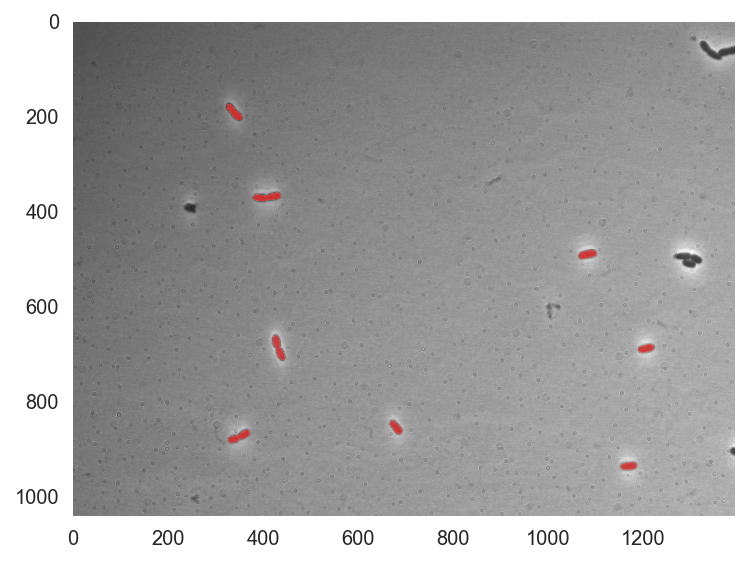

In [12]:
# Convert the phase image to a float and make a copy
phase_float = phase_im / phase_im.max()
phase_float_copy = np.copy(phase_float)

# Mark where the segmentation mask is True on the phase image. 
phase_float_copy[phase_seg > 0] = 0.8

# Color the segmented cells in red. 
merge = np.dstack((phase_float_copy, phase_float, phase_float))

# Let's take a look!
with sns.axes_style('dark'):
    skimage.io.imshow(merge)

That looks pretty great to me, let's see how many cells we were actually able to measure. 

In [13]:
# Print the total number of cells. 
print("Segmented and analyzed {num} cells!".format(num=len(mean_ints)))

Segmented and analyzed 92 cells!


Analyzing 92 cells in only 8 images in about 8 seconds is actually pretty good! That's certainly enough to do some serious boot strapping. Let's look at the ECDFs of the mean intensities and the areas. 

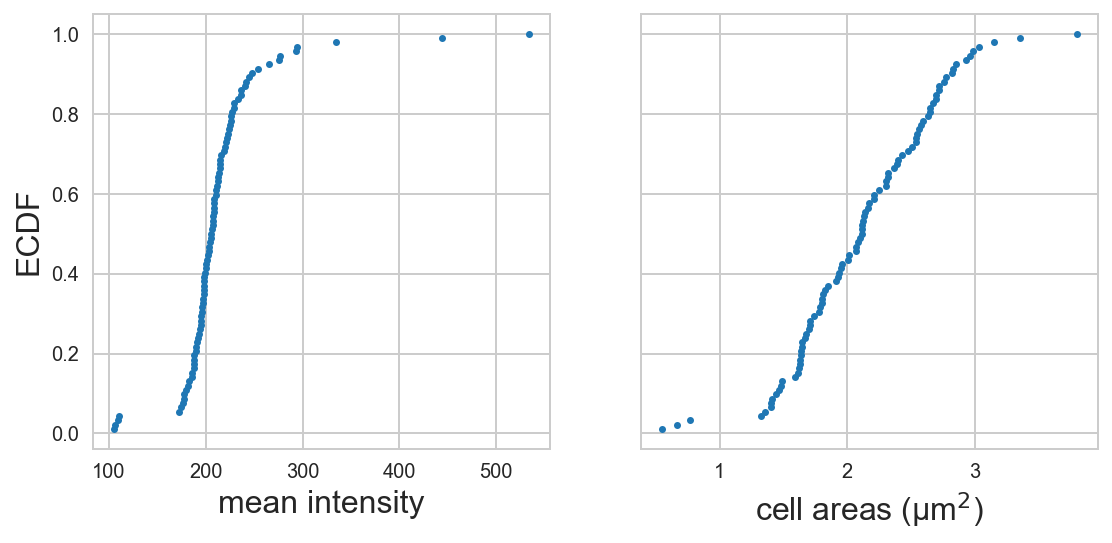

In [14]:
# Generate the ECDFs for the intensities and areas. 
means_sort, means_ecdf = bootcamp_utils.ecdf(mean_ints)
areas_sort, areas_ecdf = bootcamp_utils.ecdf(areas)

# Plot them.
fig, ax = plt.subplots(1,2, figsize=(9, 4), sharey=True)
ax[0].set_xlabel('mean intensity')
ax[0].set_ylabel('ECDF')
ax[1].set_xlabel('cell areas (µm$^2$)')

_ = ax[0].plot(means_sort, means_ecdf, marker='.', linestyle='none')
_ = ax[1].plot(areas_sort, areas_ecdf, marker='.', linestyle='none')

Let's go ahead and perform 100,000 *in silico* replicates of this experiment to get a confidence interval on our mean cell intensities.

In [15]:
# Draw bootstrap replicates of mean
bs_reps_mean = bootcamp_utils.draw_bs_reps(mean_ints, func=np.mean, size=100000)

# Draw bootstrap replicates of standard deviation
bs_reps_std = bootcamp_utils.draw_bs_reps(mean_ints, func=np.std, size=100000)

# Compute the 97.5% and 2.5% percentiles.
percs_mean = np.percentile(bs_reps_mean, [2.5, 97.5])
percs_std = np.percentile(bs_reps_std, [2.5, 97.5])

print('95% of our bootstrapped means lie between {0:.2f} and {1:.2f}.'.format(
                        percs_mean[0], percs_mean[1]))
print('95% of our bootstrapped st. devs. lie between {0:.2f} and {1:.2f}.'.format(
                        percs_std[0], percs_std[1]))

95% of our bootstrapped means lie between 203.33 and 225.42.
95% of our bootstrapped st. devs. lie between 30.83 and 75.42.
